In [1]:
import pandas as pd
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
from scipy.stats import norm

# Import and Clean Data

In [2]:
# Define variables used in Table 2 analysis
yvar          = 'amount_weekly'
endogvar      = 'jikokoa'
instrument    = 'price_USD'
clustervar    = 'respondent_id'
base_controls = ['d_charcoalbuy_KSH', 'spend50', 'savings_KSH', 'b_incomeself_KSH', 'RiskAverse', 
                 'CreditConstrained', 'b_residents','b_children', 'd_jikokoalast_years',
                 'v1_beliefs_annual_mean', 'v1_beliefs_annual_sd', '_const']

In [3]:
def import_and_clean_data(yvar,endogvar,instrument,clustervar,base_controls):

    # Import pre-cleaned data
    smsdf = pd.read_stata('./berkouwer_dean_replication/Data/Clean/SMS_clean_sms_replication.dta')
    v2df  = pd.read_stata('./berkouwer_dean_replication/Data/Clean/Visit123_analysis_replication_noPII.dta')
    v2df['_const'] = 1.0
    
    # Make treatment dummies in v2 dataframe
    v2df['I_treata_1'] = (v2df.treata == 1.).astype(int)
    v2df['I_treata_2'] = (v2df.treata == 2.).astype(int)
    v2df['I_treatc_1'] = (v2df.treatc == 1.).astype(int)
    v2df['I_treatc_2'] = (v2df.treatc == 2.).astype(int)
    treat_indicators   = ['I_treata_1','I_treata_2','I_treatc_1','I_treatc_2']

    # First stage df drops those with no visit 3 information
    df_fs = v2df[v2df.Visit3 == 1]

    # Subset by dates in SMS dataframe
    smsdf = smsdf[~smsdf.midline_date.isnull()]
    smsdf = smsdf[~smsdf.SMS_date.isnull()]
    smsdf = smsdf[smsdf.midline_date < smsdf.SMS_date]

    # Merge the dataframes together
    df = pd.merge(smsdf, v2df[v2df.Visit2 == 1], on='respondent_id', how='inner')
    
    # Impute mean for missing sms_amount_weekly_pre
    df.rename(columns={'sms_amount_weekly_pre_USD':'sms_amount_weekly_pre'}, inplace=True)
    subset   = df.sms_amount_weekly_pre.isna()
    amt_mean = np.mean(df[~subset]['sms_amount_weekly_pre'])
    df.loc[subset,'sms_amount_weekly_pre'] = amt_mean

    # Winsorize amount_weekly at 99% and convert to USD
    p99 = df.amount_weekly.quantile(0.99)
    df['amount_weekly'] = np.where(df.amount_weekly > p99,
                                   p99, df.amount_weekly)
    df['amount_weekly'] = df.amount_weekly/100.

    # Make TsinceV2 variables
    cmax = np.max(df['CsinceV2'].unique())
    for i in np.arange(1,cmax+1):
        df['TsinceV2_'+str(i)] = (df.TsinceV2 == i).astype(int)
    TsinceV2_indicators = [col for col in df.columns if 'TsinceV2_' in col]

    # Make SMS date dummies
    for i,dt in enumerate(np.sort(df.SMS_date.unique())):
        if (i != 0):
            df[f"_Idate_{i}"] = np.where(df.SMS_date == dt, 1.0, 0.0)
    SMSdate_indicators = [col for col in df.columns if '_Idate_' in col]
    
    # Define controls for each regression - WHY DO THEY DO THE FIRST STAGE SEPARATELY LIKE THIS?!
    xvars    = [endogvar,'finwtp_USD','sms_amount_weekly_pre']+SMSdate_indicators+TsinceV2_indicators+ \
               treat_indicators+base_controls
    xvars_fs = [instrument,'finwtp_USD']+treat_indicators+base_controls
    
    # Drop data with missing variables from full df
    for xvar in xvars:
        df = df[~(df[xvar].isnull()) & ~(df[xvar] == '')]
    df = df[~(df[yvar].isnull()) & ~(df[xvar] == '')]
    df = df[~(df[clustervar].isnull()) & ~(df[xvar] == '')]
    
    # Drop data with missing variables from first stage df
    for xvar in xvars_fs:
        df_fs = df_fs[~(df_fs[xvar].isnull()) & ~(df_fs[xvar] == '')]
    df_fs = df_fs[~(df_fs[endogvar].isnull()) & ~(df_fs[xvar] == '')]
    df_fs = df_fs[~(df_fs[clustervar].isnull()) & ~(df_fs[xvar] == '')]

    # Return full df and first stage df, plus x-variables used
    return df[[yvar,clustervar,instrument]+xvars], df_fs[[endogvar,clustervar]+xvars_fs], xvars, xvars_fs

In [4]:
df,df_fs,xvars,xvars_fs = import_and_clean_data(yvar,endogvar,instrument,clustervar,base_controls)

# Q1(c) - First-Stage F-Statistic

### Helper Functions

In [5]:
def run_ols_reg(df,yvar,xvars,clustervar):
    
    regdf = df.copy()
    
    # Get matrices and parameters
    X = regdf[xvars].to_numpy()
    Y = regdf[yvar].to_numpy()[:,None]
    N = X.shape[0]
    K = X.shape[1]

    # Get coefficient vector
    beta = np.linalg.inv(X.T @ X) @ X.T @ Y
    
    # Build the 'meat' of the cluster sandwich SE estimator
    clust_cov_sum = np.zeros((K,K))
    for clust in np.sort(regdf[clustervar].unique()):

        # Define data just from that cluster
        regdf_clust = regdf[regdf[clustervar] == clust]
        X_clust     = regdf_clust[xvars].to_numpy()
        y_clust     = regdf_clust[yvar].to_numpy()[:,None]

        # Do cluster robust SE formula
        u_j       = (y_clust - X_clust @ beta)
        clust_cov = X_clust.T @ u_j @ u_j.T @ X_clust
        clust_cov_sum += clust_cov

    # Get (X'X)^(-1): the 'bread' of the sandwich
    vcov = np.linalg.inv(X.T @ X)

    # Finite-sample correction
    n_clust = regdf[clustervar].unique().shape[0]
    qc      = (n_clust/(n_clust-1))*(N/(N-K))
    
    # Get standard errors of betas
    beta_SE = np.sqrt(np.diag(qc * vcov @ clust_cov_sum @ vcov))

    return beta.ravel(),beta_SE

In [6]:
def run_iv_reg(df,yvar,xvars,clustervar,instrument):
    
    regdf = df.copy()

    # Get matrices and parameters
    X = regdf[xvars].to_numpy()
    Y = regdf[yvar].to_numpy()[:,None]
    F = regdf[[instrument]+xvars[1:]].to_numpy()
    N = X.shape[0]
    K = X.shape[1]

    # Get regression onto fitted values
    PF     = F @ np.linalg.inv(F.T @ F) @ F.T
    Xtilde = PF @ X

    # Get coefficient vector
    beta_iv = np.linalg.inv(Xtilde.T @ Xtilde) @ Xtilde.T @ Y

    # Build the 'meat' of the cluster sandwich SE estimator
    clust_cov_sum = np.zeros((K,K))
    for clust in np.sort(regdf[clustervar].unique()):

        # Define data just from that cluster
        clust_idx = (regdf[clustervar] == clust).to_numpy()
        X_clust   = Xtilde[clust_idx,:]
        y_clust   = Y[clust_idx]

        # Do cluster robust SE formula
        u_j       = (y_clust - X_clust @ beta_iv)
        clust_cov = X_clust.T @ u_j @ u_j.T @ X_clust
        clust_cov_sum += clust_cov

    # Get (X'X)^(-1): the 'bread' of the sandwich
    vcov = np.linalg.inv(Xtilde.T @ Xtilde)

    # Finite-sample correction
    n_clust = regdf[clustervar].unique().shape[0]
    qc      = (n_clust/(n_clust-1))*(N/(N-K))

    # Get standard errors of betas
    beta_SE_iv = np.sqrt(np.diag(qc * vcov @ clust_cov_sum @ vcov))
    
    return beta_iv.ravel(),beta_SE_iv

### Replicate Results in Table 2, Columns 1-3

In [7]:
# OLS regression (column 1 of Table 2) - note controls here are different
xvars_ols            = [endogvar,instrument,'finwtp_USD']+base_controls
beta_ols,beta_SE_ols = run_ols_reg(df,yvar,xvars_ols,clustervar)

# Print results
print("Table 2, Column 1:")
for i in range(3):
    print(f"\tEstimate on {xvars_ols[i]}: {np.round(beta_ols[i],4)} ({np.round(beta_SE_ols[i],4)})")

Table 2, Column 1:
	Estimate on jikokoa: -1.8943 (0.2783)
	Estimate on price_USD: 0.006 (0.0128)
	Estimate on finwtp_USD: -0.005 (0.0092)


In [8]:
# First-stage regression (column 2 of Table 2)
beta_fs,beta_SE_fs = run_ols_reg(df_fs,endogvar,xvars_fs,clustervar)

# Print results
print("Table 2, Column 2:")
for i in range(2):
    print(f"\tEstimate on {xvars_fs[i]}: {np.round(beta_fs[i],4)} ({np.round(beta_SE_fs[i],4)})")

Table 2, Column 2:
	Estimate on price_USD: -0.0288 (0.0012)
	Estimate on finwtp_USD: 0.0244 (0.001)


In [9]:
# 2SLS regression (column 3 of Table 2)
beta_iv,beta_SE_iv = run_iv_reg(df, yvar, xvars, clustervar, instrument)

# Print results
print("Table 2, Column 3:")
for i in range(2):
    print(f"\tEstimate on {xvars[i]}: {np.round(beta_iv[i],4)} ({np.round(beta_SE_iv[i],4)})")

Table 2, Column 3:
	Estimate on jikokoa: -2.2774 (0.3068)
	Estimate on finwtp_USD: -0.0032 (0.0113)


### Get F-statistic 

In [10]:
beta_fs1,beta_SE_fs1 = run_ols_reg(df_fs, endogvar, xvars_fs, clustervar)
Fstat1 = (beta_fs1/beta_SE_fs1)**2
Fstat1[0]

571.5559751801592

In [11]:
beta_fs2,beta_SE_fs2 = run_ols_reg(df, endogvar, xvars_fs, clustervar)
Fstat2 = (beta_fs2/beta_SE_fs2)**2
Fstat2[0]

439.748179022805

# Q1(d) - Anderson-Rubin Confidence Interval

In [12]:
def quick_ols(Y, X, C, clusters):
    
    # Parameters 
    N = X.shape[0]
    K = X.shape[1]
    nclust = len(clusters)
    
    # Get beta coefficient
    beta = (np.linalg.inv(X.T @ X) @ X.T @ Y).ravel()
    
    # Clustered standard errors
    clust_cov_sum = np.zeros((K, K))
    for clust in clusters:
        clust_idx = (C == clust).ravel()
        X_clust   = X[clust_idx,:]
        Y_clust   = Y[clust_idx]
        u_j       = (Y_clust - X_clust @ beta[:,None])
        clust_cov = X_clust.T @ u_j @ u_j.T @ X_clust
        clust_cov_sum += clust_cov
    vcov    = np.linalg.inv(X.T @ X)
    qc      = (nclust/(nclust-1))*(N/(N-K))
    beta_SE = np.sqrt(np.diag(qc * vcov @ clust_cov_sum @ vcov))

    return beta,beta_SE

def test_beta(beta0, alpha, Y, D, F, C, clusters):
    
    # Test if beta is significant at 1-alpha level
    beta,beta_SE = quick_ols(Y=(Y - D*beta0), X=F, C=C, clusters=clusters)
    sig = int(abs(beta[0]/beta_SE[0]) > norm.ppf(1.-(alpha/2.)))
    
    return sig

def get_AR_CI(testgrid, alpha, Y, D, F, C, clusters):
    
    # Loop over testgrid of possible betas and test
    testres  = np.zeros(testgrid.shape[0])
    for i,beta0 in enumerate(testgrid):
        testres[i] = test_beta(beta0, alpha, Y, D, F, C, clusters)
        
    # Return betas for which test was not rejected
    ar_ci = testgrid[testres == 0]
    return ar_ci

In [13]:
# Define matrices of data as in slides
Y = df[yvar].to_numpy()[:,None]
D = df[endogvar].to_numpy()[:,None]
F = df[[instrument]+xvars[1:]].to_numpy()
C = df[clustervar].to_numpy()[:,None]

# Get AR confidence interval at 95% level
AR_CI    = get_AR_CI(testgrid=np.linspace(-5, 5, 1000), 
                     alpha=0.05, Y=Y, D=D, F=F, C=C, 
                     clusters=np.sort(df[clustervar].unique()))
AR_CImin = np.min(AR_CI)
AR_CImax = np.max(AR_CI)
print(f"AR Confidence Interval: [{np.round(AR_CImin,4)}, {np.round(AR_CImax,4)}] (width = {np.round(AR_CImax-AR_CImin,4)})")

AR Confidence Interval: [-2.8579, -1.7067] (width = 1.1512)


In [14]:
norm_CImin = -2.28-1.959*0.29
norm_CImax = -2.28+1.959*0.29
print(f"Normal Confidence Interval: [{np.round(norm_CImin,4)}, {np.round(norm_CImax,4)}] (width = {np.round(norm_CImax-norm_CImin,4)})")

Normal Confidence Interval: [-2.8481, -1.7119] (width = 1.1362)


# Q1(e) - Different Controls

### Exclude All Controls (including Willingness to Pay)

In [15]:
simple_xvars_iv = ['jikokoa','_const']
simple_xvars_fs = ['price_USD','_const']

# First-stage regression (column 2 of Table 2)
beta_fssimple,beta_SE_fssimple = run_ols_reg(df_fs, endogvar, simple_xvars_fs, clustervar)

# 2SLS regression (column 3 of Table 2)
beta_ivsimple,beta_SE_ivsimple = run_iv_reg(df, yvar, simple_xvars_iv, clustervar, instrument)

# Print results
print("Table 2, Column 2:")
for i in range(1):
    print(f"\tEstimate on {simple_xvars_fs[i]}: {np.round(beta_fssimple[i],4)} ({np.round(beta_SE_fssimple[i],4)})")
print("Table 2, Column 3:")
for i in range(1):
    print(f"\tEstimate on {simple_xvars_iv[i]}: {np.round(beta_ivsimple[i],4)} ({np.round(beta_SE_ivsimple[i],4)})")

Table 2, Column 2:
	Estimate on price_USD: -0.0267 (0.0016)
Table 2, Column 3:
	Estimate on jikokoa: -2.0172 (0.403)


### Exclude All Controls (except Willingness to Pay)

In [16]:
simple_xvars_iv = ['jikokoa','finwtp_USD','_const']
simple_xvars_fs = ['price_USD','finwtp_USD','_const']

# First-stage regression (column 2 of Table 2)
beta_fssimple,beta_SE_fssimple = run_ols_reg(df_fs, endogvar, simple_xvars_fs, clustervar)

# 2SLS regression (column 3 of Table 2)
beta_ivsimple,beta_SE_ivsimple = run_iv_reg(df, yvar, simple_xvars_iv, clustervar, instrument)

# Print results
print("Table 2, Column 2:")
for i in range(2):
    print(f"\tEstimate on {simple_xvars_fs[i]}: {np.round(beta_fssimple[i],4)} ({np.round(beta_SE_fssimple[i],4)})")
print("Table 2, Column 3:")
for i in range(2):
    print(f"\tEstimate on {simple_xvars_iv[i]}: {np.round(beta_ivsimple[i],4)} ({np.round(beta_SE_ivsimple[i],4)})")

Table 2, Column 2:
	Estimate on price_USD: -0.0287 (0.0012)
	Estimate on finwtp_USD: 0.0265 (0.0008)
Table 2, Column 3:
	Estimate on jikokoa: -2.0109 (0.3683)
	Estimate on finwtp_USD: 0.0023 (0.0122)


# Q1(f) - Estimate and Plot Propensity Scores

In [17]:
# Get matrices for logistic regression
xvars_prop = ['price_USD','_const']
Xlogit = df[xvars_prop].to_numpy()
Ylogit = df[endogvar].to_numpy()[:,None]

In [18]:
def logistic_log_likelihood(beta, Xlogit, Ylogit):
    return -np.sum(Ylogit*(Xlogit @ beta[:,None]) + np.log((1.0 / ( 1.0 + np.exp(Xlogit @ beta[:,None])))))

def logistic_gradient(beta, Xlogit, Ylogit):
    p = 1.0 / ( 1.0 + np.exp(- Xlogit @ beta[:,None]))
    return -(Xlogit.T @ (Ylogit-p)).ravel()

# Optimize logistic regression and get propensity scores
res = scipy.optimize.minimize(logistic_log_likelihood, x0=np.zeros(Xlogit.shape[1]), 
                              args=(Xlogit,Ylogit), method='BFGS', jac=logistic_gradient)
betalogit  = res.x
propscores = 1.0/(1.0 + np.exp(-(Xlogit @ betalogit[:,None])))
df['propscores'] = propscores

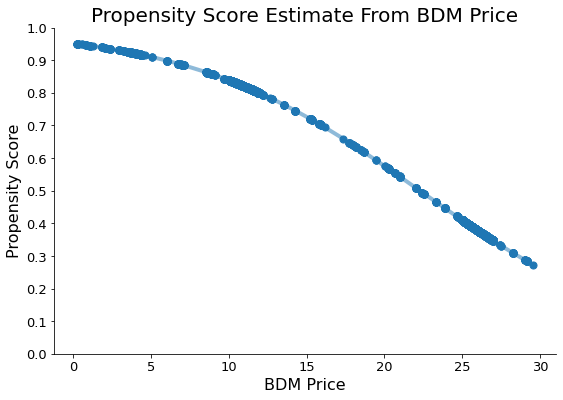

In [19]:
# Formatting stuff
fig,ax = plt.subplots(figsize=(9,6))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Do plotting
df.sort_values('price_USD', inplace=True)
ax.plot(df['price_USD'], df['propscores'], linewidth=4, alpha=0.5)
ax.scatter(df['price_USD'], df['propscores'], s=50)

# Axis formatting
ax.tick_params(axis='both', which='major', labelsize=13)
ax.set_yticks(np.arange(0.0,1.1,0.1))
ax.set_xlabel("BDM Price", size=16)
ax.set_ylabel("Propensity Score", size=16)

ax.set_title(f"Propensity Score Estimate From BDM Price", size=20)
plt.savefig(f"./q1_output/q1f_propscores.png")
plt.show()

# Q1(i) - Parametric MTE Estimator (Roy Model)

### Helper Functions

In [20]:
def probit_log_likelihood(beta, W, D):
    t  = np.longdouble(norm.cdf(W @ beta[:,None]))
    t  = np.where(t == 0.0, np.longdouble(1e-15), np.longdouble(t))
    t  = np.where(t == 1.0, np.longdouble(1.0)-np.longdouble(1e-15), np.longdouble(t))
    ll = np.sum(D*np.log(t) + (1.0-D)*np.log(np.longdouble(1.0)-t))
    return -ll

def inv_mills(u):
    num   = norm.pdf(u)
    denom = norm.cdf(u)
    return np.where(denom == 0.0, 1e200, num/denom)

def get_MTE_at_u(u, beta1, beta0, X):
    return np.mean(X @ (beta1[:-1]-beta0[:-1])[:,None] + (beta1[-1]-beta0[-1])*norm.ppf(u))

def get_MTE_curve(regdf, yvar, controlvars, endogvar, instrument, clustervar):

    # Make regression matrices
    df= regdf.copy()
    X = df[controlvars].to_numpy()
    W = df[controlvars+[instrument]].to_numpy()
    D = df[endogvar].to_numpy()[:,None]
    Y = df[yvar].to_numpy()[:,None]
    
    # Fit probit regression
    res = scipy.optimize.minimize(probit_log_likelihood, x0=np.zeros(W.shape[1]), 
                                  args=(W,D), method='BFGS')
    gamma = res.x

    # Save propensity scores and inverse mills ratios
    Wgamma       = W @ gamma[:,None]
    propscores   = norm.cdf(Wgamma)
    invmills     = inv_mills(Wgamma)
    neg_invmills = inv_mills(-Wgamma)

    # Do regressions separately for D=0 and D=1, with mills ratios
    D1subset = (df[endogvar] == 1.).to_numpy()
    D0subset = (df[endogvar] == 0.).to_numpy()
    X1 = np.hstack((X[D1subset,:], invmills[D1subset]))
    X0 = np.hstack((X[D0subset,:], invmills[D0subset]))
    beta1 = (np.linalg.pinv(X1.T @ X1) @ X1.T @ Y[D1subset]).ravel()
    beta0 = (np.linalg.pinv(X0.T @ X0) @ X0.T @ Y[D0subset]).ravel()
    
    # Get MTE curve and return it
    urange = np.arange(0.01,1.00,0.01)
    MTEs   = np.zeros(urange.shape[0])
    for i,u in enumerate(urange):
        MTEs[i] = get_MTE_at_u(u, beta1, beta0, X)
    return MTEs

def get_bootstrap_MTEs(Nboots, MTEs, df, yvar, controlvars, endogvar, instrument, clustervar):
    bootMTEs = np.zeros((Nboots, MTEs.shape[0]))
    for i in range(Nboots):
        currdf = df.sample(n=df.shape[0], replace=True)
        bootMTEs[i,:] = get_MTE_curve(currdf, yvar, controlvars, endogvar, instrument, clustervar)
        if (i+1) % 20 == 0:
            print(f"Finished {i+1} bootstraps")
    return bootMTEs

### MTE Curve Estimation

In [21]:
# Parameters for MTE estimation
controlvars = ['_const','finwtp_USD','price_USD']
urange      = np.arange(0.01,1.00,0.01)

# Get MTEs for this case and bootstrapped MTEs
MTEs     = get_MTE_curve(df, yvar, controlvars, endogvar, instrument, clustervar)
bootMTEs = get_bootstrap_MTEs(200, MTEs, df, yvar, controlvars, endogvar, instrument, clustervar)

# Get confidence intervals of MTE curves
upper = np.quantile(bootMTEs,0.975,axis=0)
lower = np.quantile(bootMTEs,0.025,axis=0)

Finished 20 bootstraps
Finished 40 bootstraps
Finished 60 bootstraps
Finished 80 bootstraps
Finished 100 bootstraps
Finished 120 bootstraps
Finished 140 bootstraps
Finished 160 bootstraps
Finished 180 bootstraps
Finished 200 bootstraps


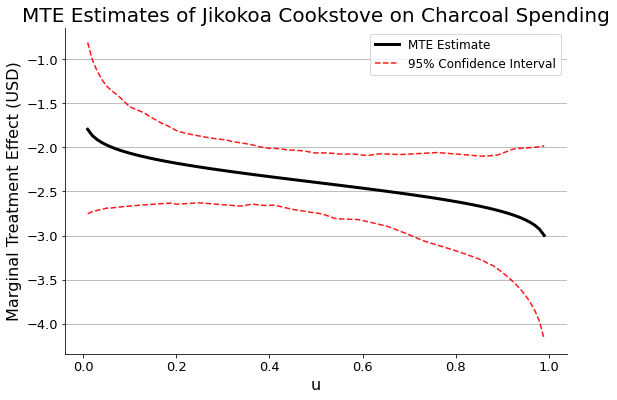

In [22]:
# Plot results
plt.show()

# Formatting stuff
fig,ax = plt.subplots(figsize=(9,6))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Do plotting
ax.plot(urange, MTEs, color='black', linewidth=3, label='MTE Estimate')
ax.plot(urange, upper, color='red', linestyle='dashed', alpha=0.9, label='95% Confidence Interval')
ax.plot(urange, lower, color='red', linestyle='dashed', alpha=0.9)

# Axis formatting
ax.tick_params(axis='both', which='major', labelsize=13)
ax.set_xlabel("u", size=16)
ax.set_ylabel("Marginal Treatment Effect (USD)", size=16)
ax.grid(axis='y')

# Legend
ax.legend(fontsize=12)

ax.set_title(f"MTE Estimates of Jikokoa Cookstove on Charcoal Spending", size=20)
plt.savefig(f"./q1_output/q1i_mte.png")
plt.show()

### ATE Estimation

In [23]:
ATE       = np.mean(MTEs)
bootATEs  = np.mean(bootMTEs,axis=0)
upper_ATE = np.quantile(bootATEs,0.025)
lower_ATE = np.quantile(bootATEs,0.975)
print(f"ATE Estimate: {np.round(ATE,3)}, 95% Confidence Interval: ({np.round(lower_ATE,3)},{np.round(upper_ATE,3)})")

ATE Estimate: -2.397, 95% Confidence Interval: (-1.919,-2.89)


### ATT and ATU Estimation

In [24]:
# Calculate weights 
weight_att = np.array([(propscores.ravel() >= u).mean() for u in urange]) / df[endogvar].mean()
weight_atu = np.array([(propscores.ravel() <  u).mean() for u in urange]) / (1.-df[endogvar].mean())

# Get parameters as weighted average of MTEs
ATT = np.average(MTEs, weights=weight_att)
ATU = np.average(MTEs, weights=weight_atu)

# Get confidence intervals from bootstraps
bootATTs = np.average(bootMTEs,weights=weight_att,axis=1)
bootATUs = np.average(bootMTEs,weights=weight_atu,axis=1)
upper_ATT = np.quantile(bootATTs,0.025)
lower_ATT = np.quantile(bootATTs,0.975)
upper_ATU = np.quantile(bootATUs,0.025)
lower_ATU = np.quantile(bootATUs,0.975)

# Print results
print(f"ATT Estimate: {np.round(ATT,3)}, 95% Confidence Interval: ({np.round(lower_ATT,3)},{np.round(upper_ATT,3)})")
print(f"ATU Estimate: {np.round(ATU,3)}, 95% Confidence Interval: ({np.round(lower_ATU,3)},{np.round(upper_ATU,3)})")

ATT Estimate: -2.271, 95% Confidence Interval: (-1.922,-2.655)
ATU Estimate: -2.597, 95% Confidence Interval: (-2.066,-3.14)


# Q1(j) - Alternative Approach

### Characterize Problem

In [25]:
df_fs['should_buy'] = (df_fs.price_USD <= df_fs.finwtp_USD).astype(float)
df_fs['violation']  = (df_fs.should_buy != df_fs.jikokoa).astype(float)
num_violations      = df_fs.violation.sum()

print(f"Number of Violations in First Stage Data: {num_violations} ({num_violations/df_fs.shape[0]*100}% of total {df_fs.shape[0]})")
df_fs[df_fs.violation == 1][['price_USD','finwtp_USD','jikokoa','should_buy','violation']]

Number of Violations in First Stage Data: 8.0 (0.8762322015334063% of total 913)


,price_USD,finwtp_USD,jikokoa,should_buy,violation
166,25.06,30.00,0.0,1.0,1.0
238,25.74,27.74,0.0,1.0,1.0
495,10.49,12.50,0.0,1.0,1.0
655,25.64,37.50,0.0,1.0,1.0
727,26.35,30.00,0.0,1.0,1.0
803,25.69,28.70,0.0,1.0,1.0
888,25.27,30.00,0.0,1.0,1.0
923,25.94,37.50,0.0,1.0,1.0


In [26]:
df['should_buy'] = (df.price_USD <= df.finwtp_USD).astype(float)
df['violation']  = (df.should_buy != df.jikokoa).astype(float)
num_violations      = df.violation.sum()

print(f"Number of Violations in SMS Data: {num_violations} ({num_violations/df.shape[0]*100}% of total {df.shape[0]})")

Number of Violations in SMS Data: 60.0 (0.7640392206799949% of total 7853)
